In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
import matplotlib.pyplot as plt
import seaborn as sns
pd.options.mode.chained_assignment = None

By opening the file that way, the Chinese characters will be removed:

In [2]:
with open('../data/labelled_data.csv', encoding='ascii', errors='ignore') as myfile:
    abstracts = pd.read_csv(myfile, index_col=0)

In [3]:
abstracts.head()

,abstract,significant
0,bone. 2018 sep 24. pii: s8756-3282(18)30355-7....,0.0
1,neurosci lett. 2018 sep 24. pii: s0304-3940(18...,yes
2,fetal pediatr pathol. 2018 sep 27:1-11. doi: 1...,yes
3,per med. 2018 sep 27. doi: 10.2217/pme-2018-00...,both
4,endokrynol pol. 2018 sep 27. doi: 10.5603/ep.a...,yes


### Cleaning of abstracts
Abstracts which are shorter than 500 characters (see labelling_of_significance_of_results for details) are removed, numbers in words are transformed to a synonyme and words are fused or expanded to not be removed by the cleaning, numbers are removed, punctuation is removed and words shorter than three characters are removed.

In [4]:
# removing abstracts shorter than 500 characters - for details see labelling_of_significance_of_results
abstracts['abstract_length'] = abstracts.abstract.str.len()
abstracts = abstracts[abstracts['abstract_length'] > 500]
abstracts = abstracts.drop('abstract_length', axis=1)

In [5]:
def easy_words(column):
    text = column.str.lower()
    
    text = text.str.replace('1,25\S+ vitamin d', 'calcitriol')
    text = text.str.replace('1,25\S+ vit d', 'calcitriol')
    text = text.str.replace('1,25\S+', 'calcitriol')

    text = text.str.replace('1,25 vitamin d', 'calcitriol')
    text = text.str.replace('1,25 vit d', 'calcitriol')
    text = text.str.replace('1,25 \S+ vitamin d', 'calcitriol')
    text = text.str.replace('1,25 \S+ vit d', 'calcitriol')
    text = text.str.replace('1,25 \S+ d', 'calcitriol')
    text = text.str.replace('1,25 \S+', 'calcitriol')
    
    text = text.str.replace('25\S+ vitamin d', 'calcitriol')
    text = text.str.replace('25\S+ vit d', 'calcitriol')
    text = text.str.replace('25\S+', 'calcitriol')
 
    text = text.str.replace('vitamin d', 'vitamind')
    text = text.str.replace('vit d', 'vitamind')
    
    text = text.str.replace('tb', 'tuberculosis')
    
    return text

In [6]:
abstracts['abstract'] = easy_words(abstracts['abstract'])

In [7]:
abstracts['abstract'] = abstracts.abstract.str.replace('\d+', '')

In [8]:
abstracts['abstract'] = abstracts.abstract.str.replace('[^\w\s]', '')

In [9]:
abstracts['abstract'] = abstracts.abstract.str.findall('\w{3,}').str.join(' ')

### Split labelled from unlabelled data

In [10]:
unlabelled_abstracts = abstracts[abstracts['significant'] == '0.0']
unlabelled_abstracts = unlabelled_abstracts.drop('significant', axis=1)

labelled_abstracts = abstracts[abstracts['significant'] != '0.0']

In [11]:
print(f'{len(labelled_abstracts)} labelled abstracts.')
print(f'{len(unlabelled_abstracts)} unlabelled abstracts.')

21752 labelled abstracts.
3228 unlabelled abstracts.


### Splitting data in train, validate, test

In [12]:
def split_train_val_test(data, targetname, percentages):
    """percentages = list with percentage of train,val,test. e.g. [0.6,0.2,0.2]
    targetname = column name of target (string). data is a dataframe"""
    train_perc = percentages[0]
    test_perc = percentages[2]
    val_perc = test_perc/(train_perc + test_perc)

    if sum(percentages) > 1:
        print('percentages don\'t sum up to more than 1! calculate again :) ')
        return None
    else:
        X_train, X_test, y_train, y_test = train_test_split(
            data.loc[:, data.columns != targetname], data[targetname],
            test_size=test_perc, random_state=42)
        X_train, X_val, y_train, y_val = train_test_split(
            X_train, y_train, test_size=val_perc, random_state=42)
        return [X_train, X_val, X_test, y_train, y_val, y_test]

In [13]:
X_train, X_val, X_test, y_train, y_val, y_test = split_train_val_test(labelled_abstracts, 'significant',
                                                                      [0.7, 0.15, 0.15])

### CountVectorizing vs. TF-IDF for getting a word/frequency matrix
min_df was set to 0.02 to ensure the very low frequency words (in our case probably authors and university names) are removed.

In [14]:
cv = CountVectorizer(min_df=0.02, max_features=300000, stop_words='english').fit(X_train['abstract'])

In [15]:
tf = TfidfVectorizer(min_df=0.02, max_features=300000, stop_words='english').fit(X_train['abstract'])

In [16]:
def count_vect(series):
    matrix = cv.transform(series)
    features = cv.get_feature_names()
    df = pd.DataFrame(matrix.todense(), columns=features)
    return df


def tf_idf(series):
    matrix = tf.transform(series)
    features = tf.get_feature_names()
    df = pd.DataFrame(matrix.todense(), columns=features)
    return df

In [17]:
cv_train_df = count_vect(X_train['abstract'])
cv_val_df = count_vect(X_val['abstract'])
cv_test_df = count_vect(X_test['abstract'])

In [18]:
cv_train_df.head()

,ability,abnormalities,absence,absorptiometry,absorption,according,achieved,acid,action,activation,...,wiley,winter,women,womens,xray,year,years,york,young,zhang
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
3,0,0,0,0,0,0,0,0,0,0,...,1,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,1,0,0,1,...,0,0,1,0,0,0,0,0,0,0


In [19]:
tf_train_df = tf_idf(X_train['abstract'])
tf_val_df = tf_idf(X_val['abstract'])
tf_test_df = tf_idf(X_test['abstract'])

In [20]:
tf_train_df.head()

,ability,abnormalities,absence,absorptiometry,absorption,according,achieved,acid,action,activation,...,wiley,winter,women,womens,xray,year,years,york,young,zhang
0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,...,0.000000,0.0,0.00000,0.0,0.0,0.0,0.0,0.0,0.000000,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,...,0.000000,0.0,0.00000,0.0,0.0,0.0,0.0,0.0,0.000000,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,...,0.000000,0.0,0.00000,0.0,0.0,0.0,0.0,0.0,0.133627,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,...,0.115806,0.0,0.00000,0.0,0.0,0.0,0.0,0.0,0.000000,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.072114,0.0,0.0,0.064535,...,0.000000,0.0,0.03813,0.0,0.0,0.0,0.0,0.0,0.000000,0.0


### MVP - Logistic Regression
Using count vectorized input data.

In [21]:
logreg_cv = LogisticRegression(random_state=42).fit(cv_train_df, y_train)

In [22]:
train_score = logreg_cv.score(cv_train_df, y_train)
val_score = logreg_cv.score(cv_val_df, y_val)

In [23]:
print(f'Accuracy for predicting the train labels: {np.round(train_score, decimals=2)}')
print(f'Accuracy for predicting the validate labels: {np.round(val_score, decimals=2)}')

Accuracy for predicting the train labels: 0.8
Accuracy for predicting the validate labels: 0.75


In [24]:
predict_train_cv = logreg_cv.predict(cv_train_df)
predict_val_cv = logreg_cv.predict(cv_val_df)

In [62]:
def cm(y_train, y_train_predict, y_val, y_val_predict):
    cm_train = confusion_matrix(y_train, y_train_predict, labels=['yes', 'no', 'both'])
    cm_train_percentage = cm_train/(cm_train.sum(axis=1, keepdims=True))

    cm_val = confusion_matrix(y_val, y_val_predict, labels=['yes', 'no', 'both'])
    cm_val_percentage = cm_val/(cm_val.sum(axis=1, keepdims=True))
    
    sns.set(font_scale=1.3)
    
    plt.figure(figsize=(20,10))
    plt.subplot(1,2,1)
    sns.heatmap(cm_train_percentage, annot=True, xticklabels=['yes', 'no', 'both'],
                yticklabels=['yes', 'no', 'both'], fmt='.2f')
    plt.title('TRAIN')
    plt.subplot(1,2,2)
    sns.heatmap(cm_val_percentage, annot=True, xticklabels=['yes', 'no', 'both'],
                yticklabels=['yes', 'no', 'both'], fmt='.2f')
    plt.title('VALIDATE')
    plt.show()

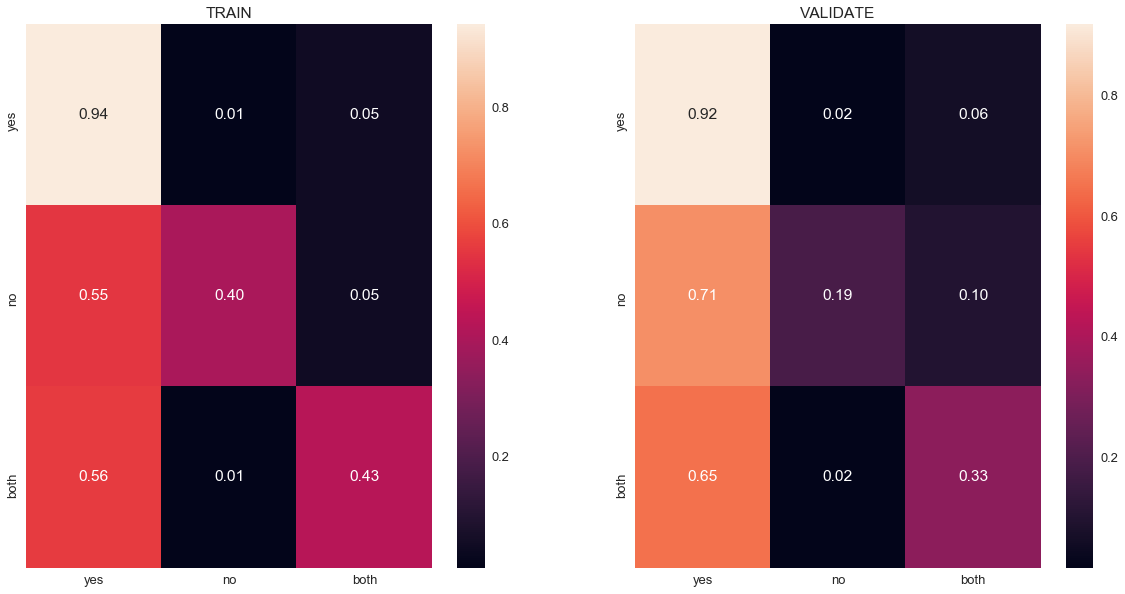

In [63]:
cm(y_train, predict_train_cv, y_val, predict_val_cv)

Most of the 'yes' papers were correctly classified (92 %), however, 'no' (18 %) and 'both' (33 %) posed difficulties, especially 'no'. Maybe this is because the major proportion of papers in the training data are labelled as 'yes'.

In [65]:
print(classification_report(y_train, predict_train_cv))

             precision    recall  f1-score   support

       both       0.69      0.43      0.53      2990
         no       0.79      0.40      0.53      1156
        yes       0.82      0.94      0.88     11080

avg / total       0.79      0.80      0.78     15226



Precision: 69 % is correctly classified as 'both', 32 % is classified as 'both' even though it's truly 'no' or 'yes'.

Recall: 24 % is correctly classified as both, but 76 % of 'both' is wrongly classified as 'yes' or 'no'.

f1-score: harmonic mean of precision and recall.

#### Logistic regression is trained with TF-IDF pre-processed data.

In [56]:
logreg_tf = LogisticRegression(random_state=42).fit(tf_train_df, y_train)

In [57]:
train_score = logreg_tf.score(tf_train_df, y_train)
val_score = logreg_tf.score(tf_val_df, y_val)

In [58]:
print(f'Accuracy for predicting the train labels: {np.round(train_score, decimals=2)}')
print(f'Accuracy for predicting the validate labels: {np.round(val_score, decimals=2)}')

Accuracy for predicting the train labels: 0.76
Accuracy for predicting the validate labels: 0.74


In [59]:
predict_train_tf = logreg_tf.predict(tf_train_df)
predict_val_tf = logreg_tf.predict(tf_val_df)

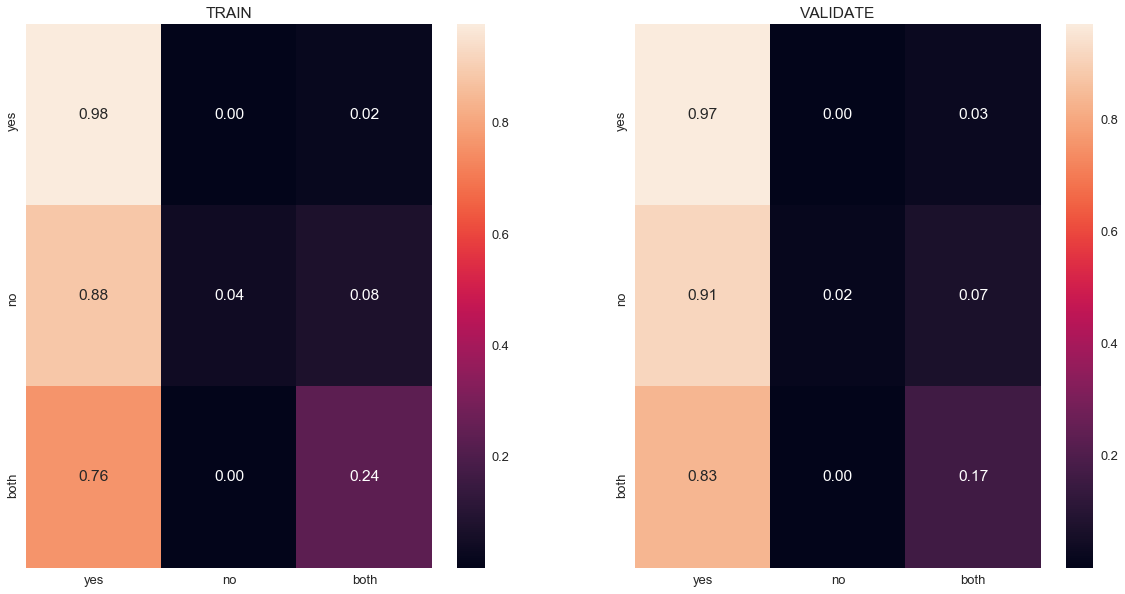

In [64]:
cm(y_train, predict_train_tf, y_val, predict_val_tf)

TF-IDF was better with classifying the 'yes' (97 % correct), however much worse with 'no' (1.3 % correct) and 'both' (17% correct). CountVectorize will be used for data preprocessing from here on out.

In [67]:
print(classification_report(y_train, predict_train_tf))

             precision    recall  f1-score   support

       both       0.68      0.24      0.35      2990
         no       0.94      0.04      0.08      1156
        yes       0.77      0.98      0.86     11080

avg / total       0.76      0.76      0.70     15226

